# SMC sequential inference for a static parameter (IBIS) for 1d Gaussian

The model is $p(y_t|y_{0:t-1},\theta)=N(y_t|\theta.\mu, \theta.\sigma^2)$.

Code is from: https://github.com/nchopin/particles/blob/master/docs/source/notebooks/SMC_samplers_tutorial.ipynb

In [12]:
import os
import seaborn as sns

try:
    import particles
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/nchopin/particles.git
    import particles
import particles.state_space_models as ssm
import particles.distributions as dists

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from scipy import stats

try:
    import particles
except ModuleNotFoundError:
    %pip install -qq particles
    import particles
from particles import smc_samplers as ssp
from particles import distributions as dists

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

In [2]:
os.environ["LATEXIFY"] = ""
os.environ["FIG_DIR"] = "figures"

In [3]:
class ToyModel(ssp.StaticModel):
    def logpyt(self, theta, t):  # density of Y_t given theta and Y_{0:t-1}
        return stats.norm.logpdf(self.data[t], loc=theta["mu"], scale=theta["sigma"])


T = 30
my_data = stats.norm.rvs(loc=3.14, size=T)  # simulated data
my_prior = dists.StructDist({"mu": dists.Normal(scale=10.0), "sigma": dists.Gamma()})

my_static_model = ToyModel(data=my_data, prior=my_prior)

We run IBIS with 20 particles, using 50 MCMC iterations per time step (data point). We use "waste free" SMC, so we generate 50*20=1000 samples in total per step.

In [4]:
%%time

my_ibis = ssp.IBIS(my_static_model, len_chain=50)
my_alg = particles.SMC(fk=my_ibis, N=20, store_history=True, verbose=True)
my_alg.run()

t=0, ESS=58.14
t=1, Metropolis acc. rate (over 49 steps): 0.209, ESS=499.06
t=2, Metropolis acc. rate (over 49 steps): 0.170, ESS=675.50
t=3, ESS=376.27
t=4, Metropolis acc. rate (over 49 steps): 0.244, ESS=583.01
t=5, ESS=103.19
t=6, Metropolis acc. rate (over 49 steps): 0.486, ESS=904.26
t=7, ESS=795.64
t=8, ESS=571.89
t=9, ESS=361.04
t=10, Metropolis acc. rate (over 49 steps): 0.363, ESS=934.31
t=11, ESS=788.41
t=12, ESS=649.73
t=13, ESS=555.55
t=14, ESS=631.81
t=15, ESS=503.48
t=16, ESS=412.39
t=17, Metropolis acc. rate (over 49 steps): 0.317, ESS=920.21
t=18, ESS=952.02
t=19, ESS=814.36
t=20, ESS=875.37
t=21, ESS=914.19
t=22, ESS=750.37
t=23, ESS=803.78
t=24, ESS=773.84
t=25, ESS=808.32
t=26, ESS=827.16
t=27, ESS=828.41
t=28, ESS=639.55
t=29, ESS=646.82
CPU times: user 739 ms, sys: 108 ms, total: 847 ms
Wall time: 842 ms


In [5]:
xx = my_alg.hist.X[0].theta["mu"]
nsamples = xx.shape[0]
print(nsamples)

1000


(30, 1000)


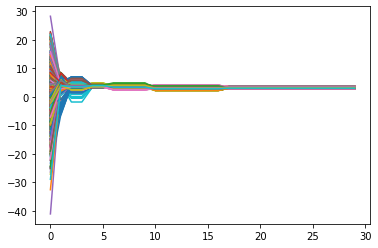

In [6]:
mus = np.zeros((T, nsamples))
times = np.arange(T)
for t in times:
    mus[t, :] = my_alg.hist.X[t].theta["mu"]

print(mus.shape)
plt.figure()
plt.plot(times, mus, label="mu");

Below we show the histogram of samples at two time steps for each parameter.
We see that the posterior concentrates on the true values.

In [14]:
pml.latexify(width_scale_factor=2)

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:71: UserWarning: renaming figures/ibis-post-histo.pdf to figures/ibis-post-histo_latexified.pdf because LATEXIFY is True
  f"renaming {fname_full} to {fname}{extention} because LATEXIFY is {LATEXIFY}",


saving image to figures/ibis-post-histo_latexified.pdf
Figure size: [3.  1.5]


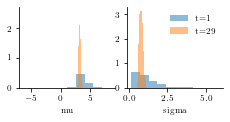

In [17]:
# plt.style.use("ggplot")
for i, p in enumerate(["mu", "sigma"]):
    plt.subplot(1, 2, i + 1)
    for t in [1, 29]:
        plt.hist(my_alg.hist.X[t].theta[p], weights=my_alg.hist.wgts[t].W, label="t=%i" % t, alpha=0.5, density=True)
    plt.xlabel(p)
plt.legend(frameon=False)
sns.despine()
pml.savefig("ibis-post-histo.pdf")

saving image to figures/ibis-ESS-vs-time_latexified.pdf
Figure size: [3.  1.5]


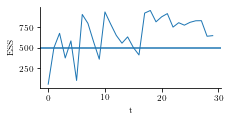

In [20]:
plt.figure()
plt.plot(my_alg.summaries.ESSs, lw=1)
plt.xlabel("t")
plt.ylabel("ESS")
plt.axhline(y=500)
sns.despine()
pml.savefig("ibis-ESS-vs-time.pdf")

In [10]:
print(my_alg.X.shared.keys())

dict_keys(['rs_flag', 'chol_cov', 'acc_rates'])


In [11]:
rates = my_alg.X.shared["acc_rates"]
print(len(rates))
for r in rates:
    print(np.mean(r))

6
0.20924065735778064
0.17029554784643025
0.24416637113848005
0.4862693673596949
0.36317537998270405
0.3167837518528394
